In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from scipy.sparse import csr_matrix

from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer
from scipy import stats
from tqdm.notebook import tqdm

import gc
%matplotlib inline

In [2]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# DEFAULT datasets
data_pass = '/kaggle/input/m5-forecasting-accuracy/'

# Calendar to get week number to join sell prices:
calendar = pd.read_csv(data_pass+'calendar.csv')
calendar.d = calendar.d.str.extract('(\d+)').astype(np.int16)
calendar = reduce_mem_usage(calendar)

Mem. usage decreased to  0.11 Mb (44.3% reduction)


In [4]:
calendar['wm_yr_wk'].unique()#[50:60]

array([11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109,
       11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118,
       11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127,
       11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136,
       11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145,
       11146, 11147, 11148, 11149, 11150, 11151, 11152, 11201, 11202,
       11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211,
       11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220,
       11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229,
       11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238,
       11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247,
       11248, 11249, 11250, 11251, 11252, 11301, 11302, 11303, 11304,
       11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313,
       11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322,
       11323, 11324,

In [5]:
# Step 1 dataset:
# Load grid with gaps and imputed sales:
file_pass = '/kaggle/input/m5-s1-clean/grid_part_1_outlier.pkl'
grid_df = reduce_mem_usage(pd.read_pickle(file_pass))

Mem. usage decreased to 1967.47 Mb (0.0% reduction)


# Step 2: Holidays

We need to get rid of Holiday effects as it will affect weekly seasonalities. To do so we will **impute Holidays with roll_mean_l7_w7**. 

The ituition behind the imputatioin: weekly sales have **biweekly seasonality** as a lot of people are on payroll. As we are building weekly dataset we **do not care about daily seasonalities**. Therefore we impute holidays with a **weekly mean lagged by one week**. 

### Important Holidays with prelude and postlude:

In [6]:
holiday_list = [("Christmas", 2,4),
("Easter", 2,4),
("Halloween", 1,0),
("IndependenceDay", 3,0),
("LaborDay", 1,0),
("MemorialDay", 2,0),
("Mother's day", 0,0),
("NewYear", 1,0),
("SuperBowl", 1,0),
("Thanksgiving", 2,4),
("ValentinesDay", 2,0)]

### Month start
Month are not exactly 4 weeks and there is a noticable difference first week of the month as people get their paychecks.

In [7]:
calendar = calendar[['wm_yr_wk','event_name_1','date','d']]

# Marker for the beginning of month:
calendar.loc[:,'month_start'] = pd.to_datetime(calendar.loc[:,'date']).dt.day < 5

In [8]:
# Holiday marker:
day_list = []
for holiday in holiday_list:
    days = list(calendar[calendar.event_name_1 == holiday[0]]['d'])
    for day in days:
        day_list += list(range(day-holiday[1], day+(holiday[2]+1)))

calendar.loc[:,'holiday'] = calendar.loc[:,'d'].isin(day_list)

In [9]:
# Add Holiday column:
grid_df = pd.merge(grid_df, calendar[['wm_yr_wk','d','month_start','holiday']], 
                   how = 'left', left_on = ['d'], right_on = ['d'])

In [10]:
# Create features
# Generate rolling lag features and control the memory usage

df_grouped = grid_df.groupby(["id"])["sales_cap_impute"]

lag = 7
w = 7
col_name = f"rolling_w{str(w)}_l{str(lag)}_mean"
grid_df[col_name] = df_grouped.transform(lambda x: x.shift(lag).rolling(w).mean()).astype(np.float16)

In [11]:
grid_df.head()

,id,item_id,store_id,d,sales,level,imputed_sales,imputed_gaps_1,imputed_gaps_23,wm_yr_wk_x,sell_price,sale_outlier_diff,sales_cap_impute,wm_yr_wk_y,month_start,holiday,rolling_w7_l7_mean
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,CA_1,1,12,11,0,0.0,0.0,11101,0.459961,0.0,12.0,11101,False,False,NaN
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,CA_1,1,2,11,0,0.0,0.0,11101,1.559570,0.0,2.0,11101,False,False,NaN
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,CA_1,1,0,11,0,0.0,0.0,11101,3.169922,0.0,0.0,11101,False,False,NaN
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,CA_1,1,0,11,0,0.0,0.0,11101,5.980469,0.0,0.0,11101,False,False,NaN
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,CA_1,1,4,11,0,0.0,0.0,11101,0.700195,0.0,4.0,11101,False,False,NaN


In [12]:
grid_df.loc[:,'holiday_lift'] = (grid_df.loc[:,"sales_cap_impute"]-grid_df.loc[:,col_name])*grid_df.loc[:,'holiday']
grid_df.loc[:,'clean_sales'] = grid_df.loc[:,"sales_cap_impute"] - grid_df.loc[:,'holiday_lift']

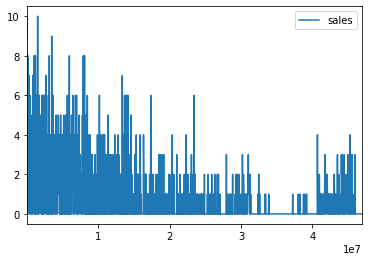

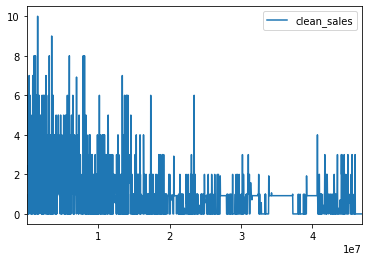

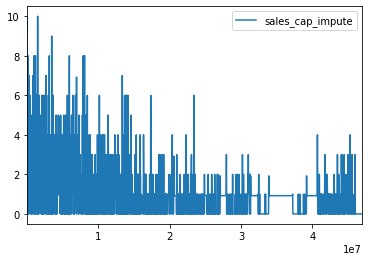

In [13]:
col = 'HOUSEHOLD_1_331_WI_3_validation'
grid_df.loc[grid_df.id==col,
            ['sales']].plot.line()
grid_df.loc[grid_df.id==col,
            ['clean_sales']].plot.line()
grid_df.loc[grid_df.id==col,
            ["sales_cap_impute"]].plot.line()

In [14]:
grid_df.id[10060:10080]

10060    HOUSEHOLD_1_331_WI_3_validation
10061    HOUSEHOLD_1_333_WI_3_validation
10062    HOUSEHOLD_1_344_WI_3_validation
10063    HOUSEHOLD_1_345_WI_3_validation
10064    HOUSEHOLD_1_347_WI_3_validation
10065    HOUSEHOLD_1_354_WI_3_validation
10066    HOUSEHOLD_1_357_WI_3_validation
10067    HOUSEHOLD_1_360_WI_3_validation
10068    HOUSEHOLD_1_362_WI_3_validation
10069    HOUSEHOLD_1_365_WI_3_validation
10070    HOUSEHOLD_1_368_WI_3_validation
10071    HOUSEHOLD_1_370_WI_3_validation
10072    HOUSEHOLD_1_372_WI_3_validation
10073    HOUSEHOLD_1_373_WI_3_validation
10074    HOUSEHOLD_1_374_WI_3_validation
10075    HOUSEHOLD_1_375_WI_3_validation
10076    HOUSEHOLD_1_376_WI_3_validation
10077    HOUSEHOLD_1_377_WI_3_validation
10078    HOUSEHOLD_1_379_WI_3_validation
10079    HOUSEHOLD_1_381_WI_3_validation
Name: id, dtype: category
Categories (30490, object): [FOODS_1_001_CA_1_validation, FOODS_1_001_CA_2_validation, FOODS_1_001_CA_3_validation, FOODS_1_001_CA_4_validation, ..., HOUS

# DANGER: np.float16

The format should be changed to np.float32 before feature engineering or training.

In [15]:
grid_df = reduce_mem_usage(grid_df)
gc.collect()

Mem. usage decreased to 2415.81 Mb (0.0% reduction)


4859

In [16]:
# Dump to pickle. :
grid_df.to_pickle('grid_s2.pkl')